# VisualNLP - Usage of Model Serving endpoints

This demo shows how to use Databrick Model Serving endpoints with VisualNLP.

Recently VisualNLP went beyond usual ways of calling AI models inference. Previous ways are limited by available hardware and its cost. Endpoints are one of new ways that help to speed up and optimize inference cost. Our models supports following options of endpoints:

*   Databricks Model Serving
*   Amazon SageMaker

Below is a sample of how to use Databricks Model Serving endpoint.



## Setup

At first we set up working environment.

In [ ]:
!wget https://www.dropbox.com/scl/fi/6zromctsqiaxf7khk2ews/samples_text_detection.tar.xz?rlkey=uuvx3uh7amvqa66ue9i54x7xs&st=mn5ep3tq&dl=0
!mv samples_text_detection.tar.xz?rlkey=uuvx3uh7amvqa66ue9i54x7xs samples_text_detection.tar.xz
!tar -xf samples_text_detection.tar.xz

In [ ]:
!wget https://www.dropbox.com/scl/fi/73ilg8ft3t2gge6xcc6qe/spark-ocr-assembly-6.1.0.jar?rlkey=rl5w002jomivf4wq7pckr70dt&st=u8x66tll&dl=0
!wget https://www.dropbox.com/scl/fi/jijs8rqgr8zmc0a6177ud/spark_ocr-6.1.0-py3-none-any.whl?rlkey=s7m8xqn19oynqwndsnym2dw2p&st=xi5djw7g&dl=0
!mv spark-ocr-assembly-6.1.0.jar\?rlkey\=rl5w002jomivf4wq7pckr70dt spark-ocr-assembly-6.1.0.jar
!mv spark_ocr-6.1.0-py3-none-any.whl\?rlkey\=s7m8xqn19oynqwndsnym2dw2p spark_ocr-6.1.0-py3-none-any.whl

In [3]:
%pip install --no-deps spark_ocr-6.1.0-py3-none-any.whl
%pip install spark-nlp pyspark==3.5.0

Processing ./spark_ocr-6.1.0-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.2/746.2 kB 10.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=1879e2bff852bd80e62016357cea340aab7f690f00acd434b1b53f4eb6f03779
  Stored in directory: /root/.cache/pip/wheels/84/40/20/65eefe766118e0a8f8e385cc3ed6e9eb7241c7e51cfc04c51a
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.9
    Uninstalling py4j-0.10.9.9:
      Successfully uninstalled py4j-0.10.9.9
  Attempting uninstall: pyspark
    Found existing installation: pyspark 4.0.1
    Uninstalling pyspark-4.0.1:
      Successfully uninstalled pyspark-4.0.1
ERROR: pip's dependency resolver does not currently take into accoun

## Initialization

Next step is to initialize Spark session and to load input data (images) to dataframe. Here we use a couple of samples - one for printed text and another one is handwritten text.

In [4]:
from pyspark.sql import SparkSession
from sparkocr import start
from pyspark import SparkConf
import sys
import os
import json

os.environ['SPARK_OCR_LICENSE'] = ""

conf = SparkConf() \
.set("spark.extraListeners", "com.johnsnowlabs.license.LicenseLifeCycleManager") \
.set("spark.sql.legacy.allowUntypedScalaUDF", "true")

spark = start(jar_path="/content", extra_conf=conf)
spark

Spark version: 3.5.0
Spark NLP version: 6.3.2
Spark OCR version: 6.1.0




    Image #0:
    Origin: file:/content/samples_text_detection/image_raw.jpg
    Resolution: 0 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


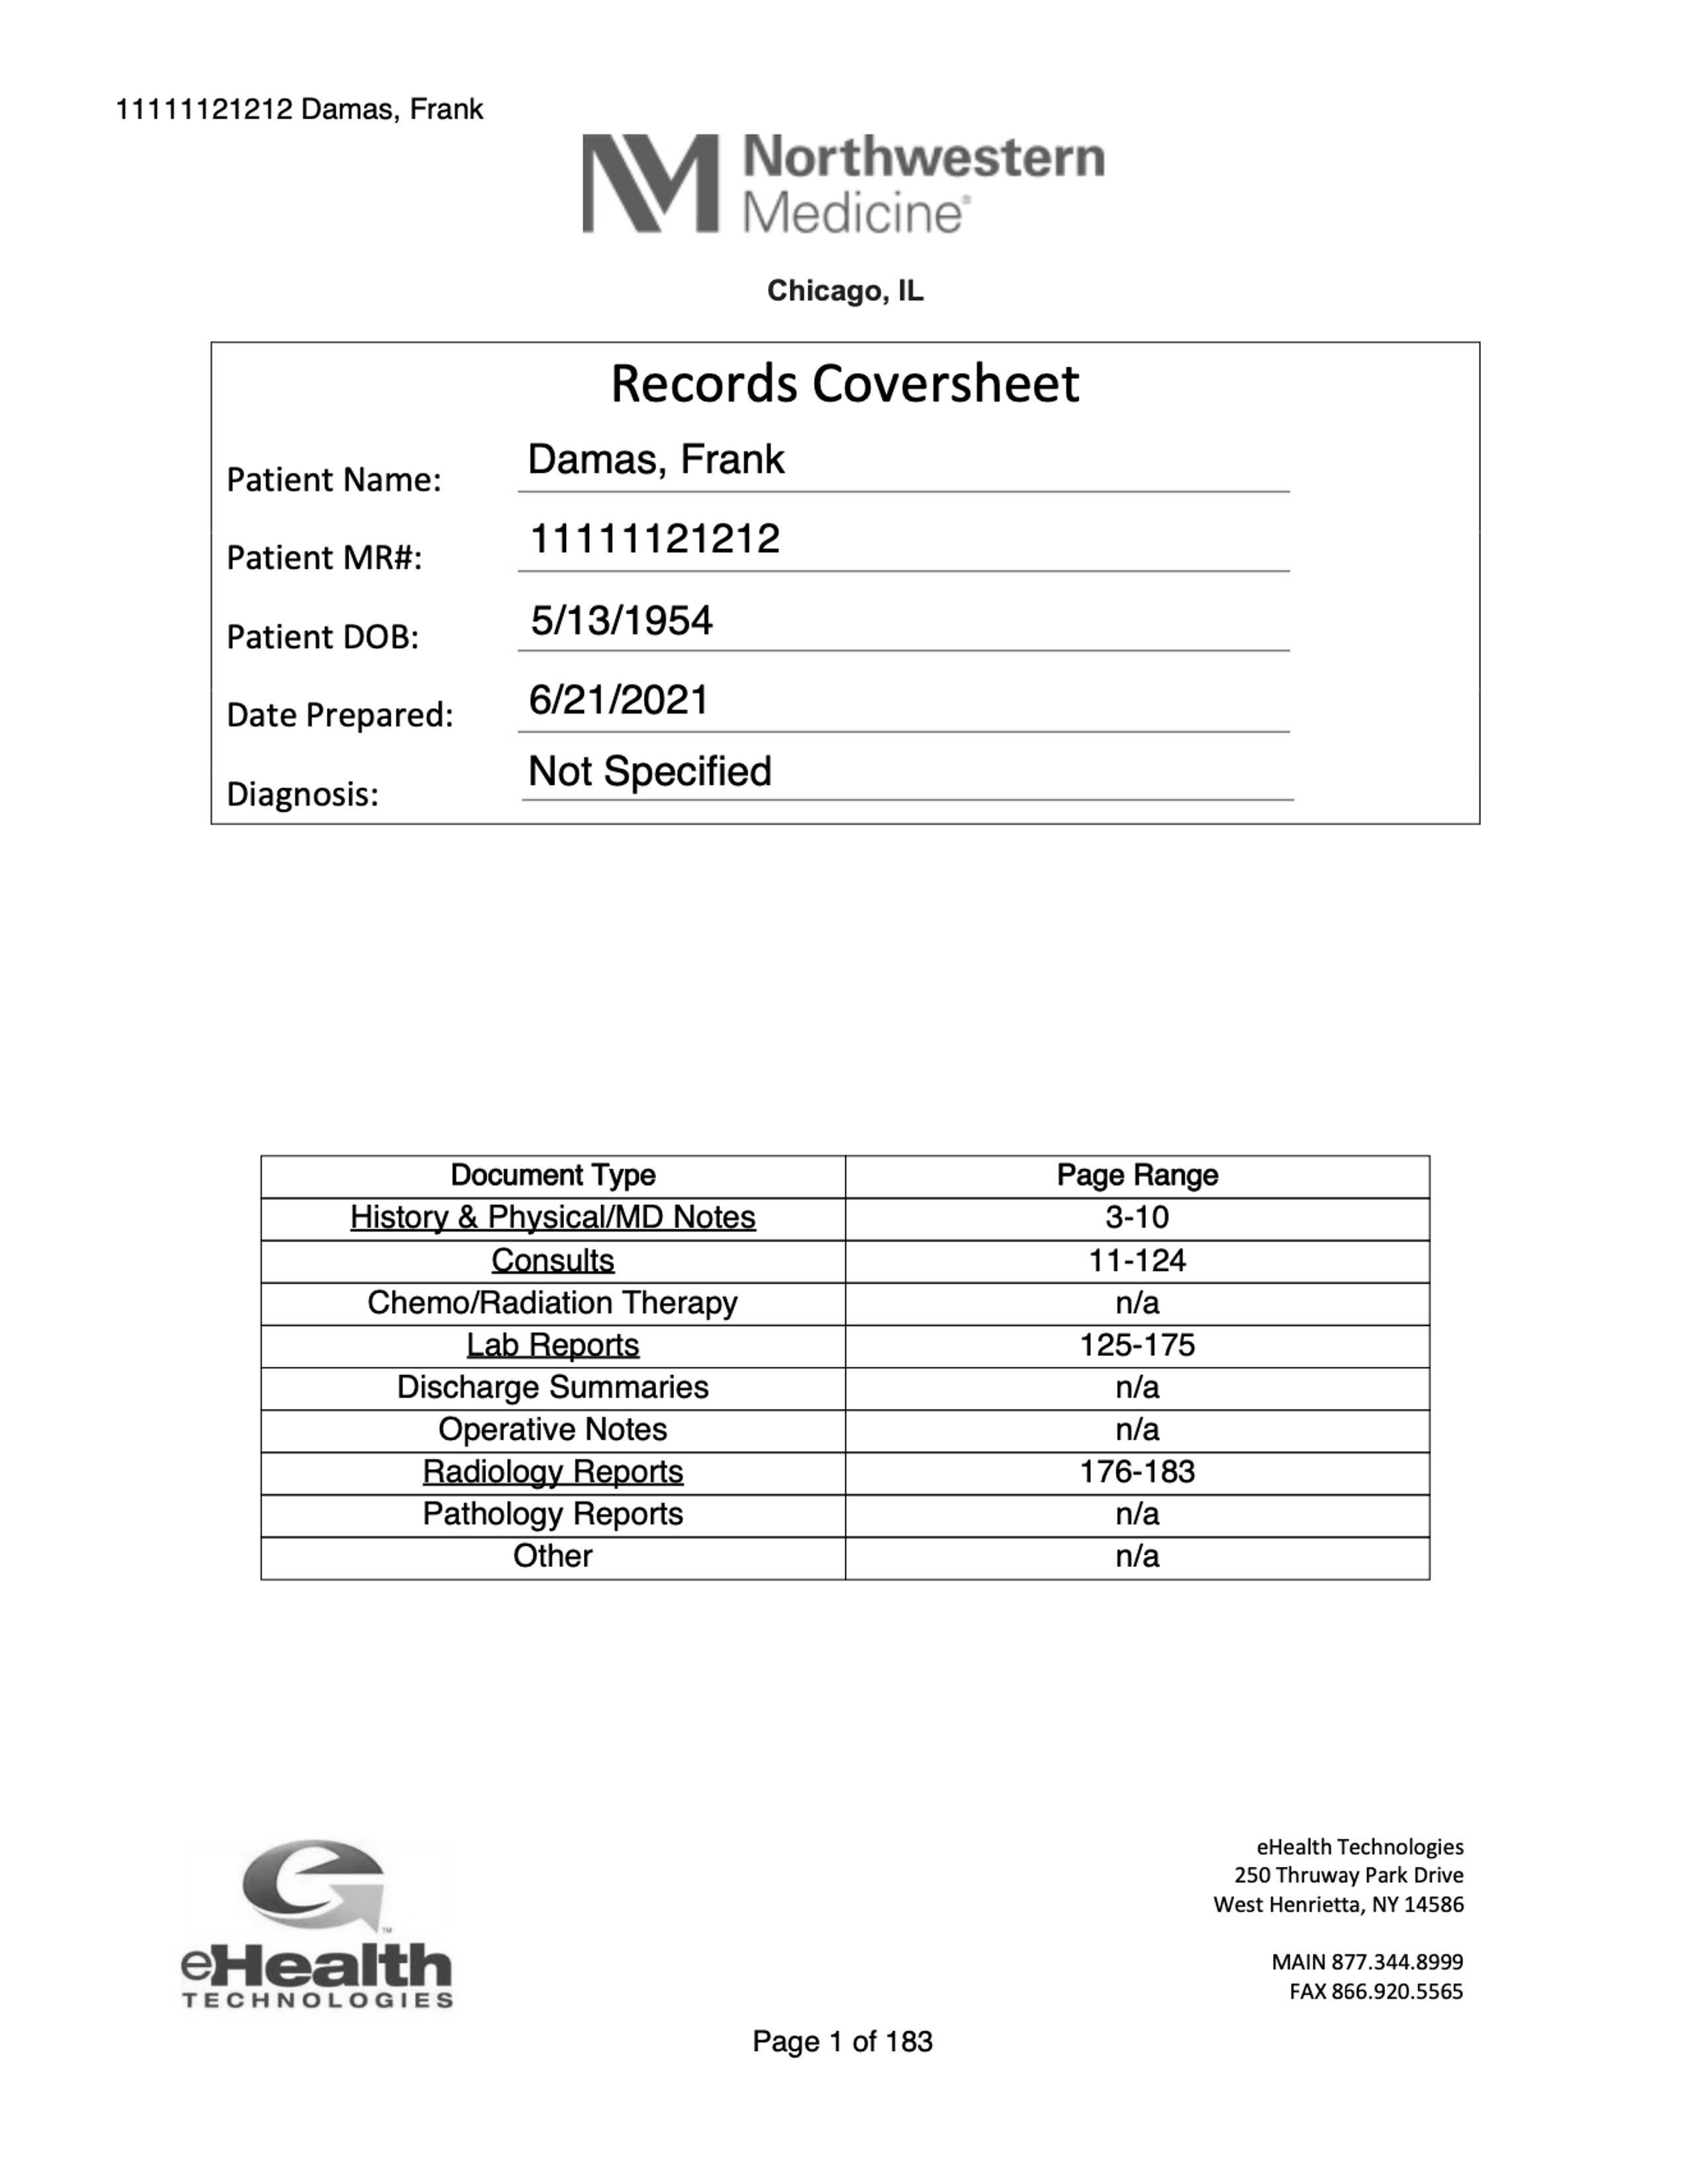


    Image #1:
    Origin: file:/content/samples_text_detection/handwritten.png
    Resolution: 0 dpi
    Width: 2774 px
    Height: 3455 px
    Mode: 10
    Number of channels: 1


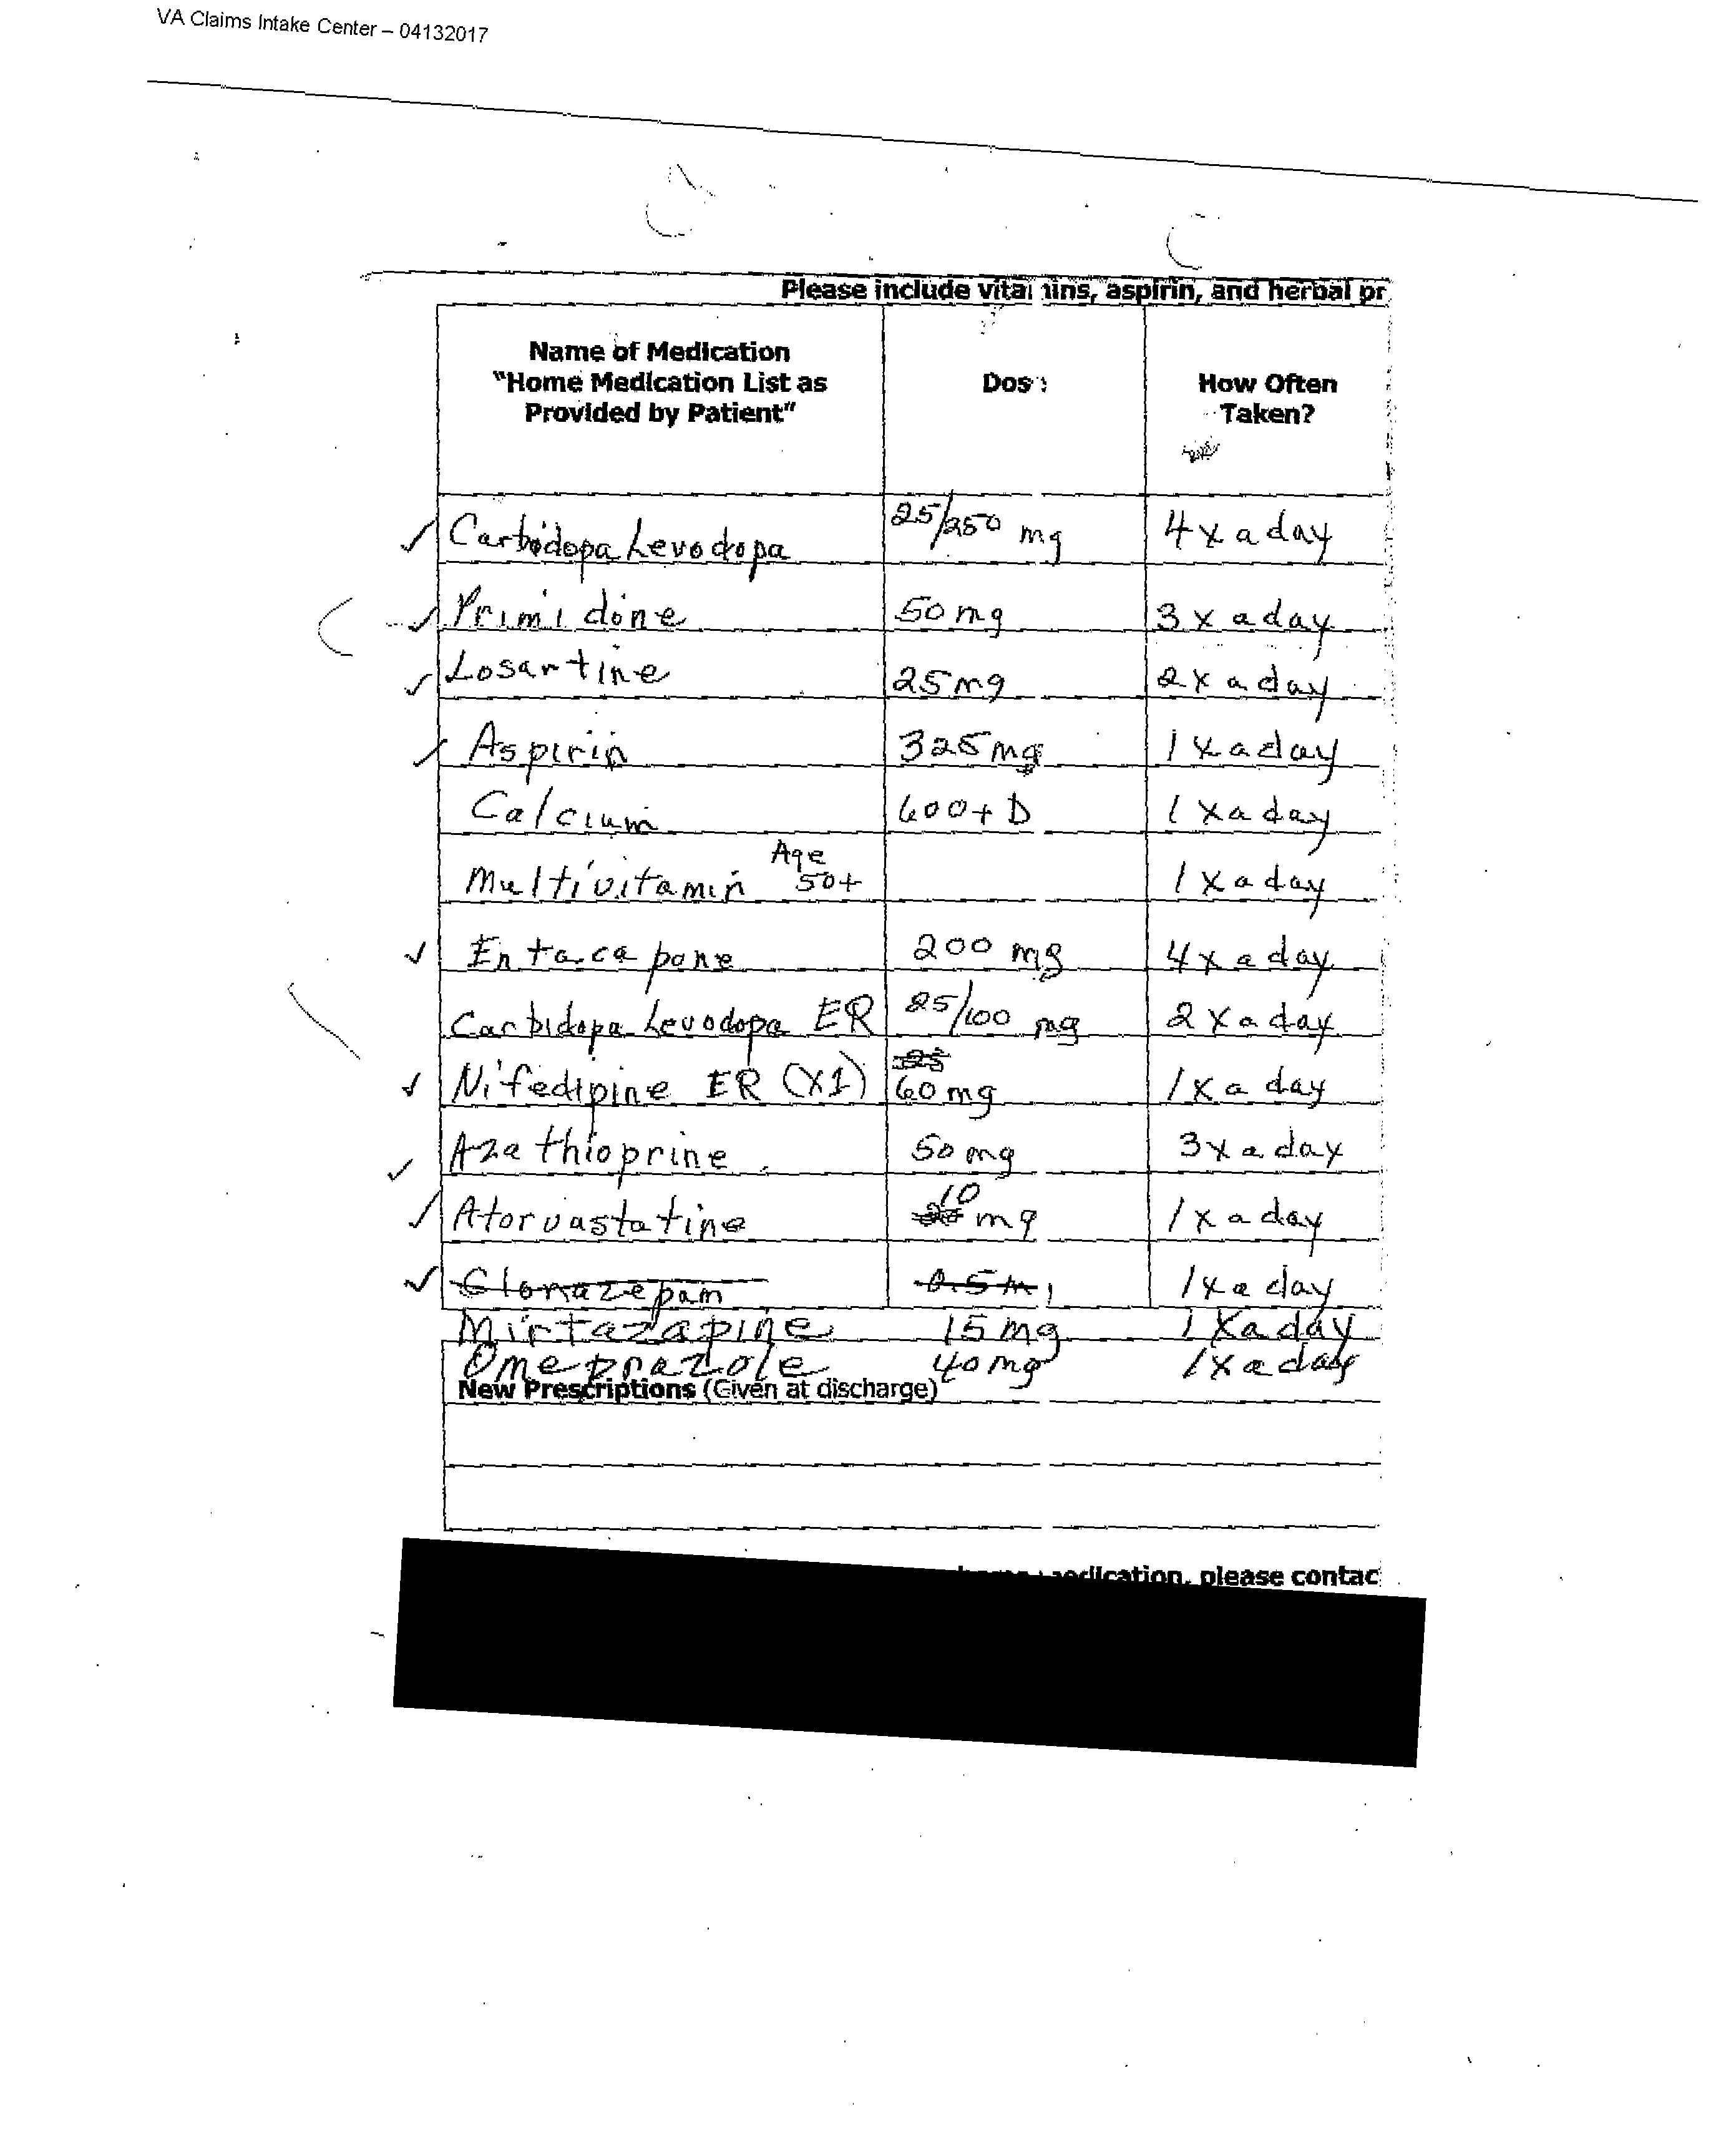

In [5]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images
from pyspark.ml import PipelineModel

df = spark.read.format("binaryFile").load("/content/samples_text_detection/*").cache()
display_images(BinaryToImage().transform(df))

## Inference

We use a pipeline to process data.



In [11]:
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.functions import udf

binary_to_image = BinaryToImage() \
    .setImageType(ImageType.TYPE_3BYTE_BGR) \
    .setKeepInput(True)

# Detect labels to deidentified in the input document
ocr = ImageToTextModelServing() \
    .setInputCol("image") \
    .setOutputCol("text") \
    .setOutputFormat(OcrOutputFormat.TEXT) \
    .setServerAddress("adb-7405606637328409.9.azuredatabricks.net") \
    .setServerPath("/serving-endpoints/jsl-vlm-7b/invocations") \
    .setServerPort(443) \
    .setServerScheme("https") \
    .setPrompt("Extract just text, no any other words") \
    .setServerToken("")

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    ocr,
])

res = pipeline.transform(df).cache()
res

image,path,modificationTime,length,content,pagenum,text,exception
{file:/content/sa...,file:/content/sam...,2026-01-15 13:25:20,355762,[FF D8 FF E0 00 1...,0,11111121212 Damas...,NULL
{file:/content/sa...,file:/content/sam...,2026-01-15 13:25:17,124151,[89 50 4E 47 0D 0...,0,Name of Medicatio...,NULL


In [15]:
for t in res.select("path", "text").collect():
  print(t["path"] + ":")
  print(" ")
  print(t["text"])
  print(" ")

file:/content/samples_text_detection/image_raw.jpg:
 
11111121212 Damas, Frank
Northwestern Medicine
Chicago, IL
Records Coversheet
Patient Name: Damas, Frank
Patient MR#: 11111121212
Patient DOB: 5/13/1954
Date Prepared: 6/21/2021
Diagnosis: Not Specified
Document Type Page Range
History & Physical/MD Notes 3-10
Consults 11-124
Chemo/Radiation Therapy n/a
Lab Reports 125-175
Discharge Summaries n/a
Operative Notes n/a
Radiology Reports 176-183
Pathology Reports n/a
Other n/a
eHealth Technologies
250 Thruway Park Drive
West Henrietta, NY 14586
MAIN 877.344.8999
FAX 868.920.3565
Page 1 of 183
 
file:/content/samples_text_detection/handwritten.png:
 
Name of Medication
Dos:
How Often
Taken?
Carbidopa-Levodopa 25/150 mg 4 x a day
Primidone 50 mg 3 x a day
Losartan 25 mg 2 x a day
Aspirin 325 mg 1 x a day
Calcium 600+D 1 x a day
Multivitamin Age 50+ 1 x a day
Enalapril 200 mg 4 x a day
Carbidopa-Levodopa ER 85/100 mg 2 x a day
Nifedipine ER (XL) 60 mg 1 x a day
Azathioprine 50 mg 3 x a day